In [9]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [138]:
def readColumnsFromFile(filename):
    
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter=",")
        
        first_line = next(reader)
        has_headers = "#" in first_line[0]
        ncol=len(first_line) # Read first line and count columns
        if not has_headers:
            infile.seek(0)
        #print(first_line)
        #infile.seek(0) 
        #has_header = csv.Sniffer().has_header(infile.read(1024))
        #infile.seek(0)
        #if has_header:
         #   next(reader)
        
        all_cols = [[] for x in range(ncol)]
        
        for row in reader:
            row_data = [float(col.strip()) for col in row] 
            all_cols = [listo+[data] for listo, data in zip(all_cols, row_data)]
            
        if has_headers:
            first_line[0] = first_line[0].replace("#", "")
            first_line = [fl.strip() for fl in first_line]
            return first_line, all_cols
        else:
            return all_cols

In [139]:
def combineAndAverageResultsArrays(resultsA, resultsB):
    
    combined_data = []
    
    for i in range(len(resultsA)):
        combined_subresult = [(x+y)/2. for x,y in zip(resultsA[i], resultsB[i])]
        combined_data.append(combined_subresult)
        
    return combined_data
        

In [171]:
event_counters_labels_testing = readColumnsFromFile('data/pyrithione-bf-thickness_histo-t=1680.0-parallel-event_counters.txt')
event_counters_labels_99res = readColumnsFromFile('data/pyrithione-t=1680.0-parallel-event_counters_sigma=0.56003.txt')
event_counters_labels_95res = readColumnsFromFile('data/pyrithione-t=1680.0-parallel-event_counters_sigma=1.00180.txt')
event_counters_labels_90res = readColumnsFromFile('data/pyrithione-t=1680.0-parallel-event_counters_sigma=1.51378.txt')

#print(counter_labels_testing[0])

################# - REDONE VALUES - ########################
#B results are the nohup ones
rough_results_REDO_A = readColumnsFromFile('data/optimal_detach_rates-range=0.01_0.0035000000000000005_0.08REDO-A.txt')
rough_results_REDO_B = readColumnsFromFile('data/optimal_detach_rates-range=0.01_0.0035000000000000005_0.08REDO-B.txt')
rough_results_REDO = combineAndAverageResultsArrays(rough_results_REDO_A, rough_results_REDO_B)

precise_results_REDO_A = readColumnsFromFile('data/optimal_detach_rates-range=0.04850_0.00019_0.05300-REDO-A.txt')
precise_results_REDO_B = readColumnsFromFile('data/optimal_detach_rates-range=0.04850_0.00019_0.05300-REDO-B.txt')
precise_results_REDO = combineAndAverageResultsArrays(precise_results_REDO_A, precise_results_REDO_B)

preciser_results_REDO_A = readColumnsFromFile('data/optimal_detach_rates-range=0.05150_0.00001_0.05170-REDO-A.txt')
preciser_results_REDO_B = readColumnsFromFile('data/optimal_detach_rates-range=0.05150_0.00001_0.05170-REDO-B.txt')
preciser_results_REDO = combineAndAverageResultsArrays(preciser_results_REDO_A, preciser_results_REDO_B)
preciser_results_REDO[0] = np.linspace(0.05150, 0.05170, 25).tolist()

chem_labels, chemical_rough_results = readColumnsFromFile('data/optimal_detach_rates-range=0.00010_0.00125_0.05000-with_chemicals.txt')

In [118]:
def plot_detach_rate_diagnostics_w_errors(dataset, pic_title):
    
    det_rs, bf_thcks, bf_thcks_err, pop_szs, pop_szs_err = dataset
    
    fig, axarr = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    bf_thcks = [x*5.0 for x in bf_thcks]
    bf_thcks_err = [x*5.0 for x in bf_thcks_err]
    
    titleSize = 12
    labelSize = 12
    numbersize = 10
    legendsize = 10
    IDsize=12
    
    axarr[0].errorbar(det_rs, bf_thcks, yerr=bf_thcks_err, fmt='-o', color='k')
    axarr[1].errorbar(det_rs, pop_szs, yerr=pop_szs_err, fmt='-o', color='#005580')
    
    #ax.set_title('Varying detachment rate', fontsize=titleSize)
    axarr[0].set_title('det rate vs thickness', fontsize=titleSize)
    axarr[0].set_xlabel('detachment rate', fontsize=labelSize)
    axarr[0].set_ylabel('biofilm thickness ($\mu$m)', fontsize=labelSize)
    
    axarr[1].set_title('det rate vs popsize', fontsize=titleSize)
    axarr[1].set_xlabel('detachment rate', fontsize=labelSize)
    axarr[1].set_ylabel('pop size', fontsize=labelSize)
    
    for ax in axarr:
        ax.locator_params(axis='x', nbins=6)
        ax.xaxis.set_tick_params(labelsize=numbersize)
        ax.yaxis.set_tick_params(labelsize=numbersize)
        #ax.set_xlim((1.-0.018)*min(det_rs), max(det_rs))
        ax.set_ylim(bottom=0)
    
    plt.savefig('plots/'+pic_title, bbox_inches='tight')
    plt.show()
    



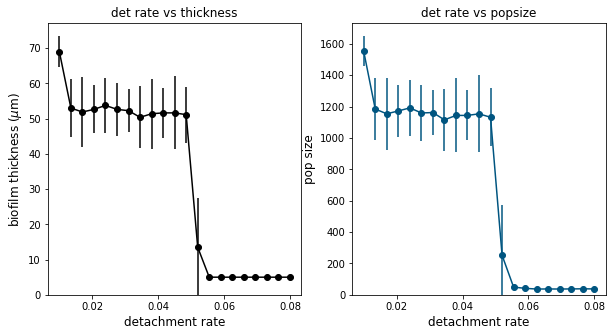

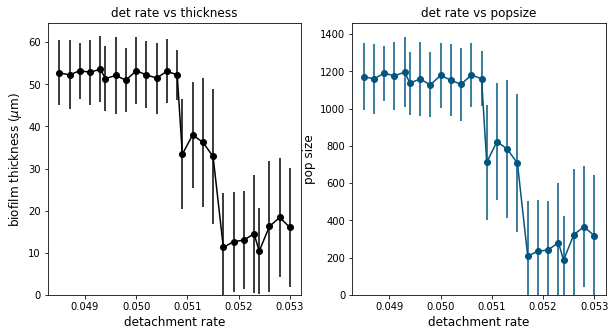

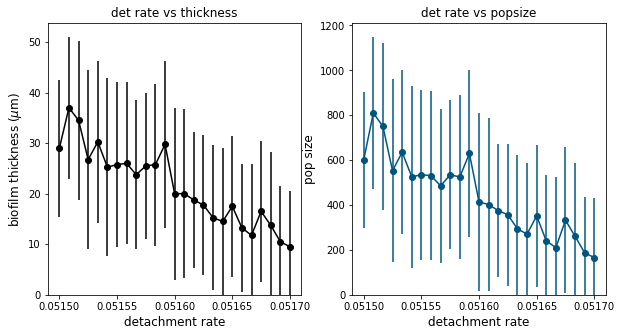

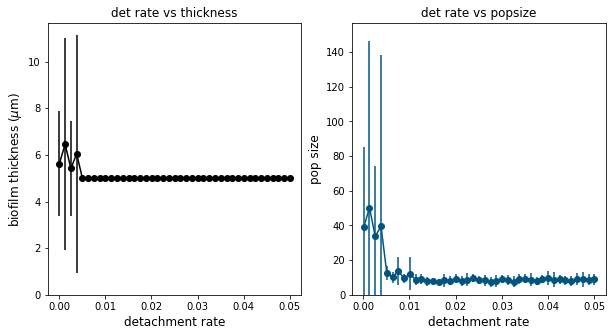

In [119]:
#plot_detach_rate_diagnostics_w_errors(precise_results,  'thickness-popsize_vs_detachrate_precise.pdf')
#plot_detach_rate_diagnostics_w_errors(precisest_results,  'thickness-popsize_vs_detachrate_precisest.pdf')
#plot_detach_rate_diagnostics_w_errors(precisest_results_2,  'thickness-popsize_vs_detachrate_precisest_2.pdf')

plot_detach_rate_diagnostics_w_errors(rough_results_REDO, 'optimal_detach_rate-rough.pdf')
plot_detach_rate_diagnostics_w_errors(precise_results_REDO, 'optimal_detach_rate-precise.pdf')
plot_detach_rate_diagnostics_w_errors(preciser_results_REDO, 'optimal_detach_rate-preciser.pdf')
plot_detach_rate_diagnostics_w_errors(chemical_rough_results, 'optimal_detach_rate_chemicals.pdf')

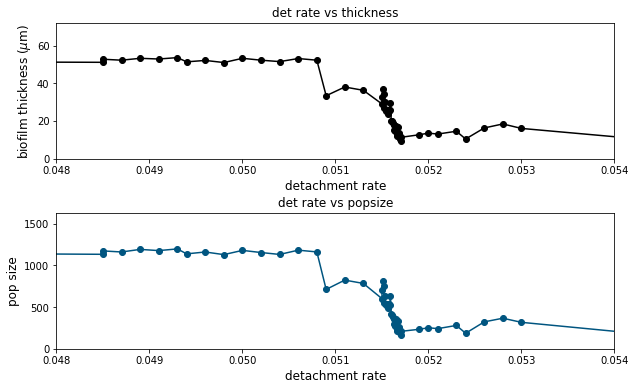

In [120]:
def collateAllResults_v2(results_matrix, pic_title):
    
    collated_results = []
    #print(len(results_matrix))
    #print(len(results_matrix[2]))
    
    for i in range(len(results_matrix[0])):
        collated_subresults = []
        for r in range(len(results_matrix)):
            collated_subresults += results_matrix[r][i]
        collated_results.append(np.array(collated_subresults))
        
    
        
    
    #print(collated_results[0])
      
    #for i in range(len(rough_res)):
     #   collated_subresults = np.array(rough_res[i] + precise_res[i] + precisest_res[i] + precisest_res2[i])
      #  collated_results.append(collated_subresults)
        
    
    #now we sort the values, as the precise ones are in the middle of the rough ones
    idx = np.argsort(collated_results[0])
    
    for i in range(len(collated_results)):
        collated_results[i] = collated_results[i][idx]
    
    det_rs, thicknesses, thick_errs, pop_size, pop_errs = collated_results
    #print(det_rs)
    #print()
    #print(thicknesses)
    
    
    fig, axarr = plt.subplots(2, 1)
    fig.set_size_inches(10, 6)
    fig.subplots_adjust(hspace=0.4)
    
    thicknesses = [x*5.0 for x in thicknesses]
    thick_errs = [x*5.0 for x in thick_errs]
    pseudo_errs = [0. for x in range(len(thick_errs))]
    
    titleSize = 12
    labelSize = 12
    numbersize = 10
    legendsize = 10
    IDsize=12
    
    axarr[0].errorbar(det_rs, thicknesses, yerr=pseudo_errs, fmt='-o', color='k')
    axarr[1].errorbar(det_rs, pop_size, yerr=pseudo_errs, fmt='-o', color='#005580')
    
    #ax.set_title('Varying detachment rate', fontsize=titleSize)
    axarr[0].set_title('det rate vs thickness', fontsize=titleSize)
    axarr[0].set_xlabel('detachment rate', fontsize=labelSize)
    axarr[0].set_ylabel('biofilm thickness ($\mu$m)', fontsize=labelSize)
    
    axarr[1].set_title('det rate vs popsize', fontsize=titleSize)
    axarr[1].set_xlabel('detachment rate', fontsize=labelSize)
    axarr[1].set_ylabel('pop size', fontsize=labelSize)
    
    for ax in axarr:
        ax.locator_params(axis='x', nbins=6)
        ax.xaxis.set_tick_params(labelsize=numbersize)
        ax.yaxis.set_tick_params(labelsize=numbersize)
        ax.set_xlim(0.048, 0.054)
        ax.set_ylim(bottom=0)
    
    plt.savefig('plots/'+pic_title, bbox_inches='tight')
    plt.show()
    
    
        
collateAllResults_v2([rough_results_REDO, precise_results_REDO, preciser_results_REDO], 'collated_optimal_det_rates.pdf')

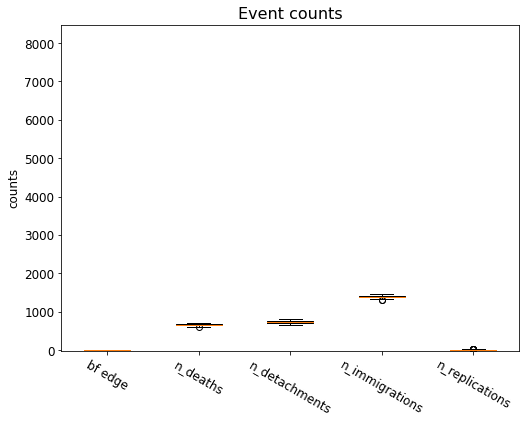

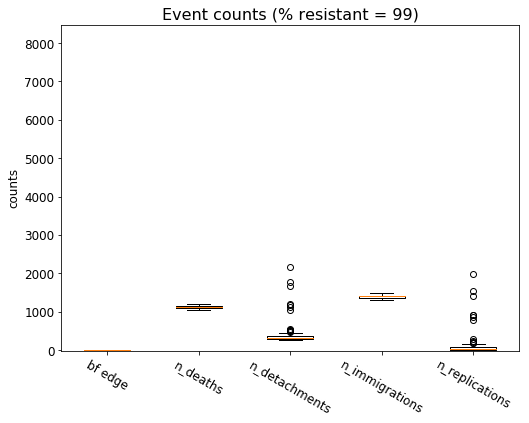

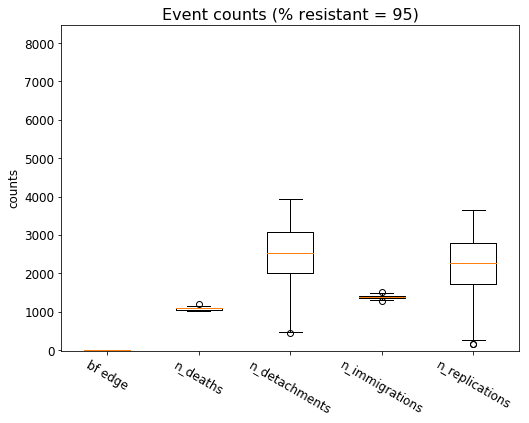

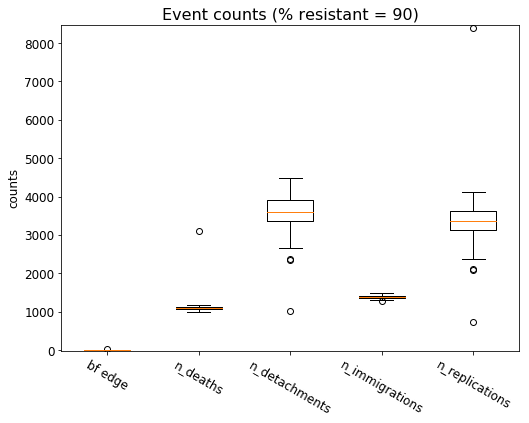

In [180]:
def box_plot_counters(counter_array_and_labels, pictitle, pc_resist_val=''):
    
    counter_labels, counter_array = counter_array_and_labels
        
    fig, ax = plt.subplots()
    
    fig.set_size_inches(8.2, 6)
    titleSize = 16
    labelSize = 12
    numbersize = 10
    legendsize = 10
    IDsize=12
    
    
    #ax.boxplot(counter_array, whis='range')
    ax.boxplot(counter_array)
    pc_label = ''
    if len(pc_resist_val) > 0:
        pc_label = ' (% resistant = '+pc_resist_val+')'
        
    ax.set_title('Event counts'+pc_label, fontsize=titleSize)
    ax.set_ylabel('counts', fontsize=labelSize)
    ax.set_ylim(-20, 8480)
    ax.set_xticklabels(counter_labels, rotation=-30)
    ax.tick_params(axis="x", labelsize=labelSize)
    ax.tick_params(axis="y", labelsize=labelSize)
    plt.savefig('plots/'+pictitle)
    plt.show()

    
box_plot_counters(event_counters_labels_testing, "event_counters_testing.pdf")
box_plot_counters(event_counters_labels_99res, "event_counters_99_resistant.pdf", '99')
box_plot_counters(event_counters_labels_95res, "event_counters_95_resistant.pdf", '95')
box_plot_counters(event_counters_labels_90res, "event_counters_90_resistant.pdf", '90')